<a href="https://colab.research.google.com/github/jm12312/PRODIGY_ML_03/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/c/dogs-vs-cats/data")

100%|██████████| 812M/812M [00:04<00:00, 174MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


In [6]:
import pandas as pd
import numpy as np
import os
import zipfile

In [9]:
with zipfile.ZipFile('dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('working/train')
with zipfile.ZipFile('dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('working/test')

In [10]:
train_dir = 'working/train/train'
test_dir = 'working/test/test1'

In [13]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        # Iterate directly through files in the image directory
        for filename in os.listdir(image_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  # Ensure we only process image files
                image_path = os.path.join(image_dir, filename)
                label = 0 if 'cat' in filename else 1  # Determine label from filename
                self.image_paths.append(image_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to the required input size for the pre-trained models
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# Create the train and test datasets
train_dataset = CustomImageDataset(image_dir=train_dir, transform=transform)
test_dataset = CustomImageDataset(image_dir=test_dir, transform=transform)

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
# for img, label in train_dataset:
#   print(img.shape)
#   print(label)
#   break
train_dataset

In [33]:
images = []
labels = []

# Collect all images and labels
for img, lbl in train_dataset:
    images.append(img.numpy())  # Convert the image to a numpy array
    labels.append(lbl)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

In [34]:
from sklearn.model_selection import train_test_split
# Flatten the images (convert from (channels, height, width) to (height * width * channels))
X_flat = X.reshape(X.shape[0], -1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Check the shapes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (20000, 3072)
Test data shape: (5000, 3072)


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an SVM classifier
clf = svm.SVC(kernel='rbf', random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      2491
           1       0.69      0.66      0.67      2509

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



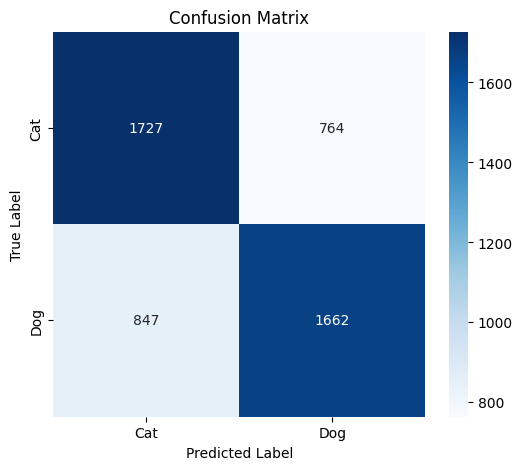

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For better visualization of the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
